# Домашнее задание "Сегментация и детекция объектов"

## Задание:

- Построить классификатор изображений рукописного ввода на базе MNIST
- Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования
- В качестве модели классификатора можно использовать любую известную модель, за исключением сверточных нейронных сетей
- Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6
- Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Загрузка данных

In [2]:
train = np.loadtxt('../datas/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('../datas/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


In [4]:
y = train[:, 0]
y.shape

(42000,)

In [5]:
X = train[:, 1:]
X.shape

(42000, 784)

## Решение задачи многоклассовой классификации на необработанных данных

### Разделение данных на обучающую и валидационную выборки

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=50)

### Обучение модели логистической регрессии

In [7]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

/home/andrew/computer_vision/venv/lib64/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

#### Оценка модели

In [8]:
val_predict = lr.predict(X_val)

In [9]:
val_accuracy = accuracy_score(y_val, val_predict)
val_accuracy

0.9169047619047619

In [10]:
confusion_matrix(y_val, val_predict)

array([[813,   0,   3,   3,   3,   5,   4,   1,   4,   2],
       [  0, 967,   5,   2,   3,   1,   1,   2,  11,   0],
       [  6,   6, 753,  23,   6,   3,  12,   6,  24,   2],
       [  2,   1,  22, 730,   0,  31,   1,   9,  25,   6],
       [  3,   4,   9,   2, 748,   3,   7,   2,   4,  27],
       [ 14,   2,   9,  19,  10, 692,  14,   4,  37,   7],
       [ 10,   1,  12,   0,   2,  11, 799,   1,   1,   0],
       [  3,   2,  10,   7,   8,   1,   0, 790,   3,  31],
       [  9,  20,  11,  20,   4,  19,   5,   2, 672,  12],
       [  2,   2,   4,  13,  19,   4,   0,  30,   7, 738]])

### Обучение модели опорных векторов

In [11]:
svm = SVC()

In [12]:
svm.fit(X_train, y_train)

SVC()

#### Оценка модели

In [13]:
val_predict = svm.predict(X_val)

In [14]:
val_accuracy = accuracy_score(y_val, val_predict)
val_accuracy

0.9771428571428571

In [15]:
confusion_matrix(y_val, val_predict)

array([[829,   0,   2,   0,   3,   1,   1,   0,   2,   0],
       [  0, 979,   6,   1,   3,   0,   0,   1,   2,   0],
       [  2,   4, 821,   2,   3,   0,   3,   2,   3,   1],
       [  0,   0,   5, 803,   0,   4,   0,   6,   4,   5],
       [  1,   3,   4,   0, 791,   0,   1,   2,   0,   7],
       [  4,   0,   0,   9,   4, 781,   6,   0,   3,   1],
       [  5,   0,   1,   0,   0,   6, 824,   0,   1,   0],
       [  0,   2,   4,   0,   6,   1,   1, 834,   1,   6],
       [  4,   2,   3,   4,   2,   3,   0,   0, 753,   3],
       [  1,   0,   1,   6,   9,   2,   0,   5,   2, 793]])

## Решение задачи много классовой классификации после снижения размерности с помощью PCA

### Предобработка изображений

In [16]:
# Центрируем данные
X_mean = X.mean(axis=0)
X -= X_mean
X.shape

(42000, 784)

In [17]:
# Матрица ковариации признаков
cov = np.dot(X.T, X) / X.shape[0]
cov.shape

(784, 784)

In [18]:
# Собственные вектора матрицы коваримции и собственные значения
U, S, _ = np.linalg.svd(cov)

In [19]:
U.shape

(784, 784)

In [20]:
S.shape

(784,)

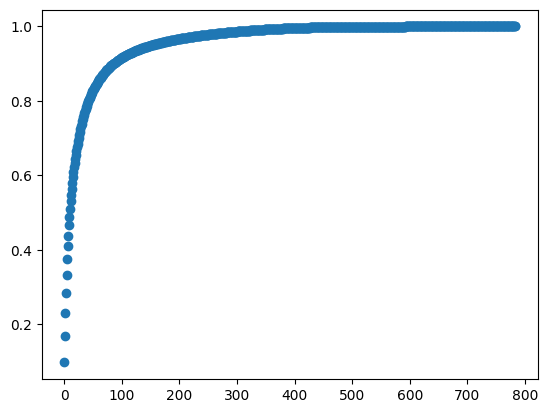

In [21]:
# Накопленная сумма собственных значений
S_cumsum = np.cumsum(S) / np.sum(S)
plt.plot(S_cumsum, 'o');

### Понижаем размерность

In [22]:
# Задаем порог накопленной суммы собственных значений
S_thr = 0.75 
# определяем необходимое число компонентов для заданного порога
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))
print(f"n_comp={n_comp} S={S_cumsum[n_comp]}")

n_comp=32 S=0.7508224380187151


In [23]:
X_reduced = np.dot(X, U[:, :n_comp])
X_reduced.shape

(42000, 32)

### Разделение данных на обучающую и валидационную выборки

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_reduced, y, test_size=0.2, random_state=50)

In [25]:
print(X_train.shape, X_val.shape)

(33600, 32) (8400, 32)


### Обучение модели логистической регрессии

In [26]:
lr_model = LogisticRegression()

In [27]:
lr_model.fit(X_train, y_train)

/home/andrew/computer_vision/venv/lib64/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

#### Оценка модели

In [28]:
val_predict = lr_model.predict(X_val)

In [29]:
val_accuracy = accuracy_score(y_val, val_predict)
val_accuracy

0.8980952380952381

In [30]:
confusion_matrix(y_val, val_predict)

array([[804,   0,   4,   3,   4,  12,   3,   2,   5,   1],
       [  0, 963,   7,   3,   3,   3,   0,   3,  10,   0],
       [  2,  24, 743,  13,  12,   5,  19,   5,  14,   4],
       [  4,   5,  26, 696,   0,  40,   6,   8,  28,  14],
       [  4,   5,  10,   0, 730,   0,  13,   3,   9,  35],
       [  9,   9,  10,  28,  13, 678,  20,   4,  26,  11],
       [ 11,   1,  10,   0,  11,  12, 785,   0,   7,   0],
       [  3,  10,  11,   3,  15,   3,   0, 777,   1,  32],
       [ 10,  18,   6,  21,   4,  27,   4,   4, 669,  11],
       [  3,   3,   8,  14,  47,   6,   0,  31,   8, 699]])

### Обучение модели опорных векторов

In [31]:
svm_model = SVC()

In [32]:
svm_model.fit(X_train, y_train)

SVC()

#### Оценка модели

In [33]:
val_predict = svm_model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predict)
val_accuracy

0.9804761904761905

In [34]:
confusion_matrix(y_val, val_predict)

array([[830,   0,   3,   0,   3,   0,   1,   0,   1,   0],
       [  0, 978,   5,   3,   3,   0,   1,   1,   1,   0],
       [  2,   2, 828,   1,   2,   0,   1,   2,   2,   1],
       [  0,   0,   4, 807,   0,   4,   0,   6,   3,   3],
       [  2,   2,   0,   0, 791,   0,   2,   3,   0,   9],
       [  2,   0,   1,   6,   2, 788,   4,   1,   1,   3],
       [  1,   0,   2,   0,   1,   2, 831,   0,   0,   0],
       [  0,   2,   6,   3,   5,   0,   0, 831,   2,   6],
       [  2,   1,   2,   3,   2,   5,   1,   0, 758,   0],
       [  2,   0,   1,   6,   8,   2,   0,   4,   2, 794]])

## Вывод:
- После понижения размерности модель логистической регрессии ухудшила, а модель опорных векторов улучшила показатели.
- Для получения прогноза на тестовой выборке будем применять `svm_model`

## Предсказание на тестовой выборке

### Предобработка изображения

In [35]:
# Центрируем данные
test_mean = test.mean(axis=0)
test -= test_mean
test.shape

(28000, 784)

In [36]:
# Матрица ковариации признаков
cov = np.dot(test.T, test) / test.shape[0]
cov.shape

(784, 784)

In [37]:
# Собственные вектора матрицы коваримции и собственные значения
U, S, _ = np.linalg.svd(cov)

In [38]:
# Накопленная сумма собственных значений
S_cumsum = np.cumsum(S) / np.sum(S)

In [39]:
# Задаем порог накопленной суммы собственных значений
S_thr = 0.75 
# определяем необходимое число компонентов для заданного порога
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))
print(f"n_comp={n_comp} S={S_cumsum[n_comp]}")

n_comp=32 S=0.7508395946896071


In [40]:
test_reduced = np.dot(test, U[:, :n_comp])
test_reduced.shape

(28000, 32)

### Предсказание

In [41]:
test_prediction = svm_model.predict(test_reduced)

In [42]:
test_prediction.shape

(28000,)

In [43]:
type(test_prediction)

numpy.ndarray

In [44]:
test_prediction[:6]

array([0., 8., 7., 7., 2., 4.])

In [51]:
df = pd.DataFrame(test_prediction)
df.index = df.index + 1
df = pd.to_numeric(df[0], downcast='integer', errors='coerce')
df.head()

1    0
2    8
3    7
4    7
5    2
Name: 0, dtype: int8

In [52]:
df.to_csv('digit_prediction.csv')